# Text Clustering

## Import Dataset

Importing the text file to a pandas dataframe by considering it to be a csv seperated by ":::"(since each sentence should be a row in the dataframe and the sentences might have "," so a character which is most unlikely to occur is used as a csv delimiter)

In [1]:
import pandas as pd

df = pd.read_csv('./text_to_cluster.txt', sep=':::', header=None)
df

/home/sourish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,0
0,Ransomware attack at Mexico's Pemex halts work...
1,#city | #ransomware | Ransomware Attack At Mex...
2,"Mexico's Pemex Oil Suffers Ransomware Attack, ..."
3,A Mexican oil company was hit by ransomware at...
4,Pemex Struck by Ransomware Attack
...,...
679,Detecting and Responding to Ransomware
680,"Emotet malware is back, more dangerous than ever"
681,Hosting provider SmarterASP.NET hit by ransomw...
682,Ransomware as a Service (RaaS) – A Contemporar...


In [2]:
document = list(df[0].values)
document[:10]

["Ransomware attack at Mexico's Pemex halts work, threatens to cripple computers",
 '#city | #ransomware | Ransomware Attack At Mexico’s Pemex Halts Work, Threatens To Cripple Computers',
 "Mexico's Pemex Oil Suffers Ransomware Attack, $4.9 Million Demanded",
 'A Mexican oil company was hit by ransomware attack',
 'Pemex Struck by Ransomware Attack',
 'Mexico’s Pemex Said It Quickly Neutralized Digital Attack',
 'Ransomware attack hits Mexican state oil firm Pemex',
 'Ransomware Attack at Mexican State Oil Firm Halts Work, Threatens to Cripple Computers – GetAps.site',
 'Mexican state oil firm Pemex hit by ransomware attack',
 'Ransomware attack on the Mexican oil giant Pemex']

In [3]:
len(document)

684

## Preprocessing

### Cleaning Text

**1. Remove characters that are not alphabets**  
        Regex is used to filter the characters that are alphabets.
  
  
**2. Remove Stopwords**  
        Remove all stopword as they donot contribute to our analysis.  
  
  
**3. Stem words**  
        Reduce words to their root value.  
        *Another alternative to this is to lemmatize the words but it takes more time than stemming.*

In [4]:
from nltk import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re

# Function to clean text
def cleanText(data):
    
    # Filter alphabets
    text = re.sub('[^a-zA-Z]', ' ', data)
    # Lowercase and tokenize words
    words = nltk.word_tokenize(text.lower())
    stops = set(stopwords.words('english'))
    # Stem words and remove stpwords
    stemmer = PorterStemmer()
    lem_words = [stemmer.stem(w) for w in words if w not in stops]
    return ' '.join(lem_words)

In [5]:
X_clean = []
for i in range(len(document)):
    X_clean.append(cleanText(document[i]))
X_clean[:10]

['ransomwar attack mexico pemex halt work threaten crippl comput',
 'citi ransomwar ransomwar attack mexico pemex halt work threaten crippl comput',
 'mexico pemex oil suffer ransomwar attack million demand',
 'mexican oil compani hit ransomwar attack',
 'pemex struck ransomwar attack',
 'mexico pemex said quickli neutral digit attack',
 'ransomwar attack hit mexican state oil firm pemex',
 'ransomwar attack mexican state oil firm halt work threaten crippl comput getap site',
 'mexican state oil firm pemex hit ransomwar attack',
 'ransomwar attack mexican oil giant pemex']

### Visualizing the Word Cloud of the data

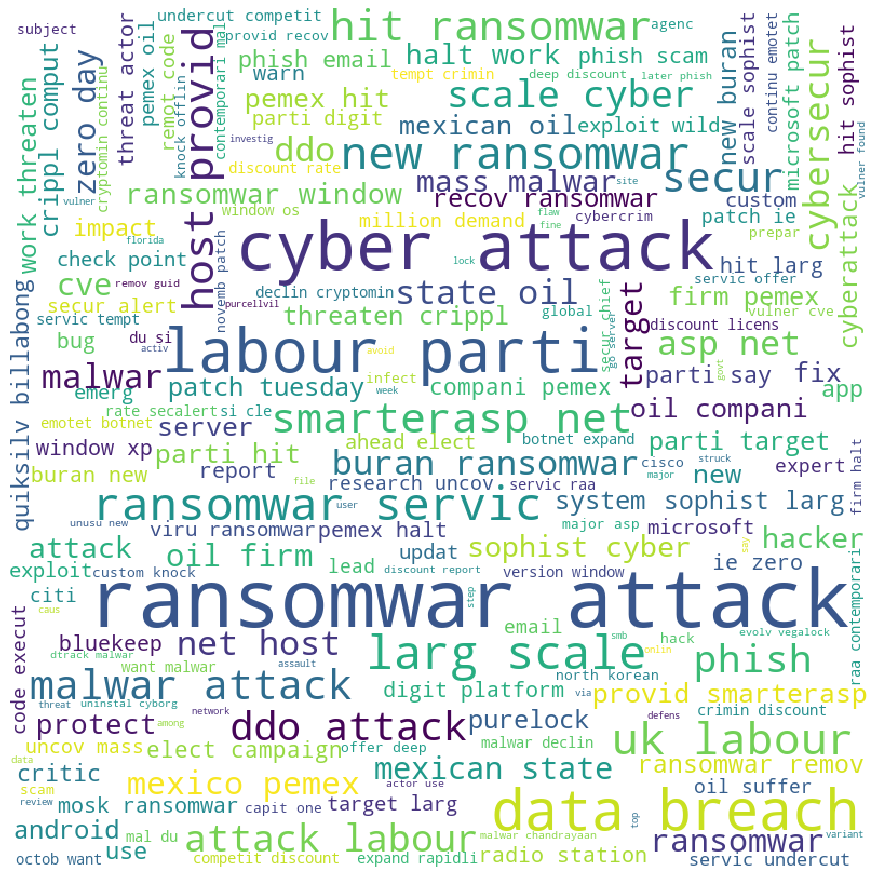

In [6]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white').generate(' '.join(X_clean)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Vectorizing the corpus

Tf-Idf Vectorizer is used to vectorize the corpora to pass it through the clustering the model.  
TfidfVectorizer is used over CountVectorizer as Countvectorizer simply computes the frequency of the token in the document but Tfidf calculates the term frequency and also also how recurrent that term is in the entire corpora which is more helpful in determining the imporatnce of the token in the corpora.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X_clean)
# get list of features vectorized by the vectorizer
features = vectorizer.get_feature_names()
print("No. of features = ", len(features))

No. of features =  831


### Dendrogram of the data

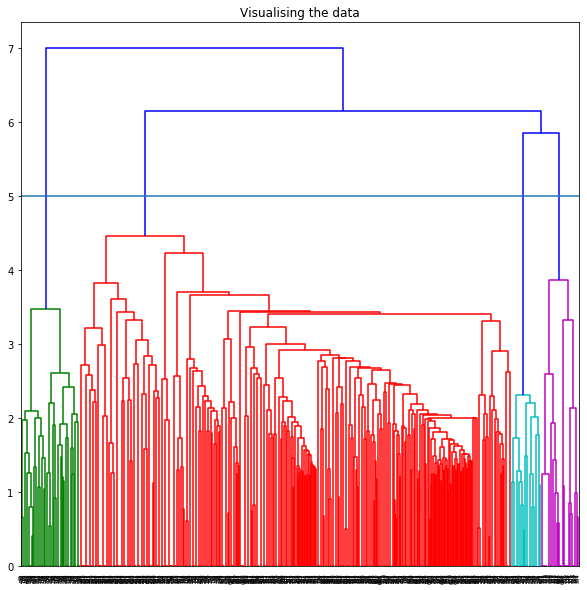

In [8]:
import scipy.cluster.hierarchy as shc 

plt.figure(figsize =(10, 10)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(X.toarray(), method ='ward')))
plt.axhline(y=5)

From the above dendrogram, we can intuitively say that the minimum number of clusters would be 4.

In [9]:
import math

# intuitively determined from dentrogram
min_cluster = 4

# calculate the maximum number of clusters using a general formula
max_cluster = round(math.sqrt(len(df)/2))

## Clustering

### Kmeans Elbow Method
  
Elbow method is used to determine the optimal number of clusters. Two measures are used -  
1. **Inertia** - Sum of squared distances of samples to their closest cluster center.  
2. **Distortion** - Average of the squared distances from the cluster centers of the respective clusters.

In [10]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
from kneed import KneeLocator

sse = {}
distortions = {}

for k in range(min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=k).fit(X)
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_
    distortions[k] = sum(np.min(cdist(X.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

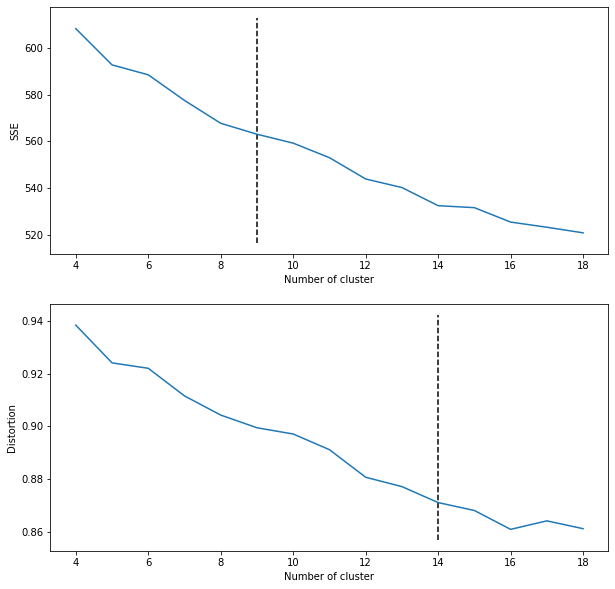

In [11]:
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
# Find the elbow in the inertia graph
sse_kn = KneeLocator(list(sse.keys()), list(sse.values()), 
                     curve='convex', direction='decreasing', 
                     interp_method='polynomial')
plt.vlines(sse_kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.subplot(2, 1, 2)
plt.plot(list(distortions.keys()), list(distortions.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Distortion")
# Find the elbow in the distortion graph
dis_kn = KneeLocator(list(distortions.keys()), list(distortions.values()), 
                     curve='convex', direction='decreasing', 
                     interp_method='polynomial')
plt.vlines(dis_kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.show()

### Calculation of Silhouette Score

Since we have two knee values from each of the graph, the silhoutte score is calculated to evaluate the clusters. The value of k for which the silhoutte score is more is taken for final clustering.
  
Silhouette score is considered for evaluation (over other measures like- Calinski-Harabasz Index and Davies-Bouldin Index etc.) as it is bounded between -1 for incorrect clustering and +1 for highly dense clustering.

In [12]:
from sklearn.metrics import silhouette_score

score = {}
for k in [sse_kn.knee, dis_kn.knee]:
    try:
        model = KMeans(n_clusters=k, init='k-means++')
        clusters = model.fit_predict(X)
        score[k] = silhouette_score(X.toarray(), clusters, metric='euclidean')
        print(k, '-> ', score[k])
    except Exception as e:
        print('Value of k could not be calculated graphically')

try:
    opt_score = max(score.values())
    k = list(score.keys())[list(score.values()).index(opt_score)]
except Exception as e:
    print('Values of k could not be calculated by the graphs, so default k = 13 is chosen')
    k=13

print('Optimal k is : ', k)

9 ->  0.07805312954898945
14 ->  0.10295008276208369
Optimal k is :  14


### Clustering using K-means clustering algorithm

On evaluation, the kmeans seems to give the best clusters. Hence, K-means is used for clustering over density based and hierarchical clustering.

In [13]:
kmeans = KMeans(n_clusters=k, init='k-means++')
clusters = kmeans.fit_predict(X)
df['cluster'] = clusters
df = df.sort_values('cluster')
df

,0,cluster
536,Android Rat – The FatRat Pentesting Tool for G...,0
144,CVE-2019-15225/15226: Envoy 1.11.1 vulnerabili...,0
630,"Red Dead Redemption 2 ultrawide, multimonitor,...",0
631,"Red Dead Redemption 2 ultrawide, multimonitor,...",0
145,Adobe Patches Critical Remote Code Execution B...,0
...,...,...
562,Check Point September 2019 top malware,13
561,Researchers discover massive increase in Emote...,13
124,Mass Malware Attack,13
578,North Korean Malware Attack Strikes Indian Nuc...,13


## Saving the Output to a file

In [14]:
with open('output.txt', 'w+') as file:
    for i in range(max(clusters)+1):
        file.write(f'cluster id: {i}\n')
        file.write('\n'.join(list(df[df['cluster']==i][0])))
        file.write('\n' + '*'*100 + '\n')